In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

Load data

In [2]:
class PixelDataset(Dataset):
    def __init__(self, photo_path, highlighted_path):
        photo = np.array(Image.open(photo_path)) / 255.0
        highlighted = np.array(Image.open(highlighted_path))[:, :, 0:1] / 255.0
        assert photo.shape[:2] == highlighted.shape[:2]
        self.photo = np.einsum('ijk->kij', photo.astype(np.float32))
        self.highlighted = highlighted.astype(np.float32)
        self.shape = photo.shape[:2]
        self.size = 33
        self.skip = 2
        self.grid = (
            (self.shape[0]-self.size)//self.skip,
            (self.shape[1]-self.size)//self.skip
        )

    def __len__(self):
        return self.grid[0] * self.grid[1]
    
    def __getitem__(self, i):
        i, j = self.skip * i // self.grid[1], self.skip * i % self.grid[1]
        return [
            self.photo[:, i:i+self.size, j:j+self.size],
            self.highlighted[i+self.size//2, j+self.size//2]
        ]

dataset = PixelDataset("nurdles_train.jpg", "nurdles_train.png")
for nin, nout in DataLoader(
    dataset,
    batch_size=16,
    shuffle=True
):
    print(nin.dtype, nout.dtype)
    print(nin.shape, nout.shape)
    break

torch.float32 torch.float32
torch.Size([16, 3, 33, 33]) torch.Size([16, 1])


Model

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        dims = [4, 4, 4, 4]
        self.main = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 33x33
            nn.Conv2d(3, dims[0], 5, 1, 0, bias=False),
            nn.ZeroPad2d(-2),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.2, inplace=True),
            # 4 x 25x25
            nn.Conv2d(dims[0], dims[1], 5, 1, 0, bias=False),
            nn.ZeroPad2d(-2),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.2, inplace=True),
            # 4 x 17x17
            nn.Conv2d(dims[1], dims[2], 5, 1, 0, bias=False),
            nn.ZeroPad2d(-2),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.2, inplace=True),
            # 4 x 9x9
            nn.Conv2d(dims[2], dims[3], 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 5x5
            nn.Conv2d(dims[3], 1, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            # 1 x 1x1
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

model = Model()
print(model)

Model(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (3): ZeroPad2d(padding=(-2, -2, -2, -2), value=0.0)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): ZeroPad2d(padding=(-2, -2, -2, -2), value=0.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (11): ZeroPad2d(padding=(-2, -2, -2, -2), value=0.0)
    (12): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(4, 4, kerne

Training

In [4]:
dataloader = list(DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005, betas=(0.9, 0.999))


lossFun = torch.nn.BCELoss()
flatten = torch.nn.Flatten()

print("ADAM")
count = 0
for epoch in range(1, 5+1):
    print("Epoch", epoch)
    for nin, nout in dataloader:
        optimizer.zero_grad()
        output = flatten(model(nin))
        loss = lossFun(output, nout)
        loss.backward()
        optimizer.step()
        
        count += 1
        if count % 200 == 0:
            print("Iteration {} - loss = {}".format(count, loss.item()))

ADAM
Epoch 1
Iteration 200 - loss = 0.0034902654588222504
Iteration 400 - loss = 0.016052182763814926
Iteration 600 - loss = 0.0009482937166467309
Iteration 800 - loss = 0.0004684137529693544
Iteration 1000 - loss = 0.0018251147121191025
Iteration 1200 - loss = 0.012111477553844452
Iteration 1400 - loss = 0.0007604454294778407
Iteration 1600 - loss = 0.0003112567646894604
Iteration 1800 - loss = 0.00014985208690632135
Iteration 2000 - loss = 0.0006070506060495973
Iteration 2200 - loss = 0.0424683578312397
Iteration 2400 - loss = 0.0018667482072487473
Iteration 2600 - loss = 0.0002546235918998718
Iteration 2800 - loss = 0.00017614390526432544
Iteration 3000 - loss = 0.00011501117114676163
Iteration 3200 - loss = 0.0003617873298935592
Epoch 2
Iteration 3400 - loss = 0.0026166923344135284
Iteration 3600 - loss = 0.020725373178720474
Iteration 3800 - loss = 0.00015147641533985734
Iteration 4000 - loss = 0.0015440162969753146
Iteration 4200 - loss = 0.0005605461192317307
Iteration 4400 - lo

Calculate running mean and variance

In [5]:
dataloader = list(DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True
))

for nin, nout in dataloader:
    with torch.no_grad():
        output = flatten(model(nin))
        loss = lossFun(output, nout)
        print(loss)

tensor(0.0015)


Export

In [6]:
import os
os.system("rm weights/*")

param_i = 0
bn_i = 0
bns = []
for param in model.parameters():
    data = param.data
    shape = '_'.join(map(str, data.shape))
    if len(data.shape) == 1:
        name = "bn{}{}".format(bn_i//2, bn_i%2)
        bns.append((name, data))
        bn_i += 1
        continue
    name = "w{:02d}_{}".format(param_i, shape)
    data.numpy().astype(np.float32).tofile("weights/"+name+".bin")
    param_i += 1

bn_i = 0
for layer in model.main:
    if layer.__class__.__name__ != "BatchNorm2d":
        continue
    layer.track_running_stats = False  # freeze
    mu = layer.running_mean
    var = layer.running_var
    name = "bn{}2".format(bn_i)
    bns.append((name, mu))
    name = "bn{}3".format(bn_i)
    bns.append((name, var))
    bn_i += 1

bns.sort()
for name, data in bns:
    s = '[' + ', '.join(map(str, data.numpy())) + ']'
    print(f"{name}: {s},")

bn00: [1.5067475, 0.73462236, 0.9027463],
bn01: [1.0160867, -0.5190285, 0.42915004],
bn02: [0.6691655, 0.6620227, 0.6227424],
bn03: [0.006436822, 0.0065827384, 0.007982741],
bn10: [1.3520912, 0.8920276, 1.2923803, 1.0416291],
bn11: [-0.37641674, -0.3698626, -0.06813239, -1.20616],
bn12: [5.098454, -0.07922329, -1.5588161, 12.819611],
bn13: [16.921711, 20.866167, 17.406403, 48.901127],
bn20: [1.1458615, 0.9962743, 0.7491567, 1.1077212],
bn21: [-1.4370297, -0.20699756, -1.573737, 0.25815344],
bn22: [-2.7830803, 1.5557672, -4.217627, 1.8538486],
bn23: [75.8165, 25.582893, 20.978085, 24.738379],
bn30: [0.7774884, 1.4483851, 1.2628847, 0.7937931],
bn31: [0.92373097, -0.033770848, 1.3037564, 0.2659414],
bn32: [4.62958, 0.3990834, 5.1560297, -0.58347964],
bn33: [22.434797, 27.502625, 30.352474, 19.078442],
bn40: [0.95617354, 1.1717262, 1.0471597, 0.9096549],
bn41: [1.3659971, 0.15213971, 0.7811826, 1.448209],
bn42: [11.527573, -3.5671787, 6.5716677, 16.242535],
bn43: [47.819103, 20.99566, 28.

https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

In [7]:
import torch.onnx

x = torch.randn(1, 3, dataset.size, dataset.size, requires_grad=True)
torch_out = model(x)

torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

Visualize

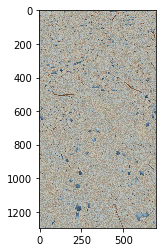

/u/d/chenj941/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


torch.Size([1, 3, 1296, 694])
(1264, 662)


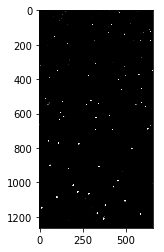

torch.Size([23421, 3, 33, 33])
0.7959590989921708 secs
torch.Size([23421, 1, 1, 1])


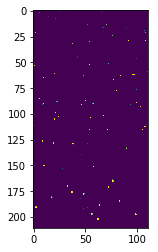

In [8]:
photo = np.array(Image.open("nurdles_test.jpg")) / 255.0
plt.imshow(photo)
plt.show()
photo = np.einsum('ijk->kij', photo.astype(np.float32))
photo = torch.tensor([photo])

print(photo.shape)
with torch.no_grad():
    output = model(photo)
    output = np.array(output)[0][0]
print(output.shape)
output = np.einsum('kij->ijk', [output, output, output])
output = (255.0*output).astype(np.uint8)
plt.imshow(output)
plt.show()

size = dataset.size
skip = 6
frames = []
for i in range(0, photo.shape[2]-size, skip):
    for j in range(0, photo.shape[3]-size, skip):
        frames.append(photo[:, :, i:i+size, j:j+size][0].numpy())
ni = len(range(0, photo.shape[2]-size, skip))
nj = len(range(0, photo.shape[3]-size, skip))
with torch.no_grad():
    frames = torch.tensor(frames)
    print(frames.shape)

    from time import perf_counter
    t0 = perf_counter()
    output = model(frames)
    t1 = perf_counter()
    print(t1-t0, "secs")

    print(output.shape)
    output = np.array(output).reshape((ni, nj))
output = (255.0*output).astype(np.uint8)
plt.imshow(output)
plt.show()